## SrWac - analiza

In [1]:
# Opšti paketi
import re
import itertools
import numpy as np
import pandas as pd
import spacy
import string

# NLP alati
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gensim - za LDA
import gensim
from gensim import corpora, models
import itertools
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from pprint import pprint
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from gensim.models import LdaModel

# BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Dimenzionalna redukcija (koristi je BERTopic)
import umap

# Vizualizacija (ako budeš htela kasnije)
import matplotlib.pyplot as plt

# Sklearn - ako bude potrebno za vektore ili dodatnu analizu
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Preuzimanje NLTK resursa (prvi put)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Izbaci warnings
import warnings
warnings.filterwarnings("ignore")

/Users/isidoragataric/miniconda3/envs/isi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Definišem stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [3]:
# Učitavanje podataka
data = []

with open("srwac_sentiment_utf8.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")  # ili .split(",") ili .split("  ")
        if len(parts) == 2:
            data.append(parts)

df = pd.DataFrame(data, columns=["text", "sentiment"])
df

,text,sentiment
0,text,sentiment
1,"""""""i počeli sa radom. Svaki dan su nosili decu...",negativan
2,P 300 V = 600 60 DRUGA GODINA 1. 1.01.10 Tehno...,negativan
3,mentalnom razvijenošću ili neadekvatnim školov...,negativan
4,. Kako prepoznati diskalkulično dete? U proces...,negativan
...,...,...
1347,"""""""razredu. Tad me je učiteljica natjerala da ...",pozitivan
1348,"""""""Ali ja sam iz osnovne škole donijela jako d...",pozitivan
1349,"""""""napravili od fakulteta SKOLU... Ovde ima da...",pozitivan
1350,"""""""od fakulteta SKOLU... Ovde ima da se uci, u...",pozitivan


In [4]:
# Čišćenje teksta
# -----------------------------------------------------
# 1. Učitavanje fajla sa kolonama "text" i "sentiment"
# -----------------------------------------------------
df = pd.read_csv("srwac_sentiment_utf8.txt", sep="\t", encoding="utf-8")

# Provera
print("Učitano:", df.shape)
print(df.head())

# -----------------------------------------------------
# 2. Definisanje funkcije za čišćenje teksta
# -----------------------------------------------------
def clean_text(text):
    if pd.isna(text):
        return "", []

    # 1. Uklanjanje ličnih imena (NER)
    doc_ner = nlp(text)
    ents_to_remove = [ent for ent in doc_ner.ents if ent.label_ == 'PERSON']
    intervals = [(ent.start_char, ent.end_char) for ent in ents_to_remove]
    intervals = sorted(intervals, reverse=True)
    for start, end in intervals:
        text = text[:start] + ' ' + text[end:]

    # 2. Standardno čišćenje
    text = text.lower()
    text = re.sub(r"[^a-zA-Zćčžšđ' ]", ' ', text)  # zadrži srpska slova
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Ručno definisane reči za izbacivanje
    custom_remove_words = {
    'a', 'ako', 'ali', 'alibo', 'ališta', 'barem', 'baš', 'bez', 'bi', 'bih', 'bio', 'bili', 'bila', 'bile',
    'bilo', 'bismo', 'biti', 'bog', 'bude', 'budem', 'budemo', 'budete', 'budu', 'budući', 'bila', 'bilo',
    'ce', 'će', 'ćemo', 'ćete', 'ću', 'ćeš', 'čak', 'često', 'da', 'daje', 'dakle', 'dalje', 'dali',
    'danas', 'do', 'dobar', 'dobro', 'dok', 'dole', 'dosad', 'dosta', 'drugi', 'druga', 'drugo', 'duž',
    'gde', 'ga', 'hoće', 'hoću', 'hoćeš', 'hoćemo', 'hoćete', 'i', 'iako', 'ih', 'ili', 'imam', 'imamo',
    'imate', 'ima', 'imaju', 'imao', 'inače', 'ipak', 'itd', 'iz', 'iza', 'između', 'ja', 'je', 'jedan',
    'jedna', 'jedno', 'jer', 'jesam', 'jesi', 'jeste', 'jesu', 'još', 'ju', 'kad', 'kada', 'kakav', 'kao',
    'kasnije', 'kako', 'kod', 'koja', 'koje', 'koji', 'koju', 'ko', 'kog', 'koga', 'kojeg', 'kojima',
    'koju', 'kroz', 'li', 'malo', 'manje', 'meni', 'me', 'mi', 'moj', 'moja', 'moje', 'moji', 'moram',
    'moramo', 'morate', 'mora', 'moraju', 'možda', 'može', 'možemo', 'možete', 'mogu', 'na', 'nad',
    'nakon', 'nam', 'nama', 'nas', 'naš', 'naša', 'naše', 'naši', 'ne', 'neće', 'nećemo', 'nećete', 'neću',
    'nešto', 'nego', 'neka', 'neke', 'neki', 'nekog', 'nekoga', 'nemam', 'nemamo', 'nemate', 'nema',
    'nemaju', 'nemaš', 'nemaš', 'nema', 'nema', 'nešto', 'ni', 'nije', 'nikad', 'nikada', 'niko', 'ništa',
    'niti', 'no', 'novi', 'novo', 'nov', 'o', 'od', 'odmah', 'oko', 'on', 'ona', 'oni', 'ono', 'opet',
    'osim', 'po', 'pod', 'ponekad', 'ponovo', 'posle', 'poslije', 'pre', 'pred', 'prema', 'pri', 'puno',
    'putem', 'sam', 'samo', 'samog', 'samo', 'smo', 'sad', 'sada', 'se', 'sebe', 'sebi', 'si', 'smo',
    'ste', 'su', 'svaki', 'svaka', 'svako', 'sve', 'svi', 'svim', 'svog', 'svoga', 'svoj', 'svoja', 'svoje',
    'ta', 'tada', 'taj', 'tako', 'takođe', 'tačno', 'te', 'tebe', 'tebi', 'ti', 'tim', 'tko', 'to', 'toga',
    'tog', 'toj', 'tom', 'tome', 'tu', 'tvoj', 'tvoja', 'tvoje', 'u', 'uglavnom', 'uz', 'vam', 'vama',
    'vas', 'vaš', 'vaša', 'vaše', 'već', 'veoma', 'vi', 'više', 'vrlo', 'za', 'zar', 'zato', 'zbog', 'ćeš',
    'ću', 'ćemo', 'ćete', 'će', 'što', 'štaviše', 'što', 'želim', 'želimo', 'želite', 'žele', 'želi', 'želiš'
    }

    # 4. Tokenizacija i filtriranje
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_remove_words]

    # 5. Lemmatizacija
    doc = nlp(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc if token.lemma_.isalpha() and token.lemma_ not in custom_remove_words]

    cleaned_text = ' '.join(lemmas)
    return cleaned_text, lemmas

# -----------------------------------------------------
# 3. Čišćenje celog korpusa
# -----------------------------------------------------
clean_results = df['text'].apply(lambda t: clean_text(str(t)))
df['cleaned_text'] = clean_results.apply(lambda x: x[0])
df['tokens_list'] = clean_results.apply(lambda x: x[1])

# -----------------------------------------------------
# 4. Provera rezultata
# -----------------------------------------------------
print(df[['text', 'cleaned_text']].head())

# Ako želiš da vidiš koliko je sve očišćeno:
print("\nPrimer tokena:\n", df['tokens_list'].iloc[0])

Učitano: (1351, 2)
                                                text  sentiment
0  "i počeli sa radom. Svaki dan su nosili decu n...  negativan
1  P 300 V = 600 60 DRUGA GODINA 1. 1.01.10 Tehno...  negativan
2  mentalnom razvijenošću ili neadekvatnim školov...  negativan
3  . Kako prepoznati diskalkulično dete? U proces...  negativan
4  "koja bi nas eventualno izvukla iz blata. Veru...  negativan
                                                text  \
0  "i počeli sa radom. Svaki dan su nosili decu n...   
1  P 300 V = 600 60 DRUGA GODINA 1. 1.01.10 Tehno...   
2  mentalnom razvijenošću ili neadekvatnim školov...   
3  . Kako prepoznati diskalkulično dete? U proces...   
4  "koja bi nas eventualno izvukla iz blata. Veru...   

                                        cleaned_text  
0  počeli sa radom nosili čudno ponašala arhive o...  
1  p v godina tehnološki sistemi procesi operacio...  
2  mentalnom razvijenošću neadekvatnim školovanje...  
3  prepoznati diskalkulično dete procesu

2025-10-23 21:14:28,389 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████████████████████████████| 43/43 [00:06<00:00,  6.60it/s]
2025-10-23 21:14:34,990 - BERTopic - Embedding - Completed ✓
2025-10-23 21:14:34,991 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-23 21:14:44,873 - BERTopic - Dimensionality - Completed ✓
2025-10-23 21:14:44,874 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-23 21:14:44,966 - BERTopic - Cluster - Completed ✓
2025-10-23 21:14:44,969 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-23 21:14:45,083 - BERTopic - Representation - Completed ✓


📊 Sažetak tema:
    Topic  Count                                               Name  \
0     -1    606                         -1_matematika_sa_pa_fizika   
1      0    103  0_statistika_finansijska_finansijska matematik...   
2      1     79                               1_ds_sns_sps_izborna   
3      2     66                           2_matematika_mene_ide_pa   
4      3     43                3_ispit_takmičenje_takmičenja_škola   
5      4     42                               4_deca_dece_uci_dete   
6      5     35                            5_dinara_evra_eura_cena   
7      6     33                6_srpski_ispit_srpski jezik_završni   
8      7     31               7_nauka_formule_matematičke_najbolji   
9      8     31       8_predmeta matematika_učenje_predmeta_časova   

                                      Representation  \
0  [matematika, sa, pa, fizika, hemija, jezik, tr...   
1  [statistika, finansijska, finansijska matemati...   
2  [ds, sns, sps, izborna, izborna matematik

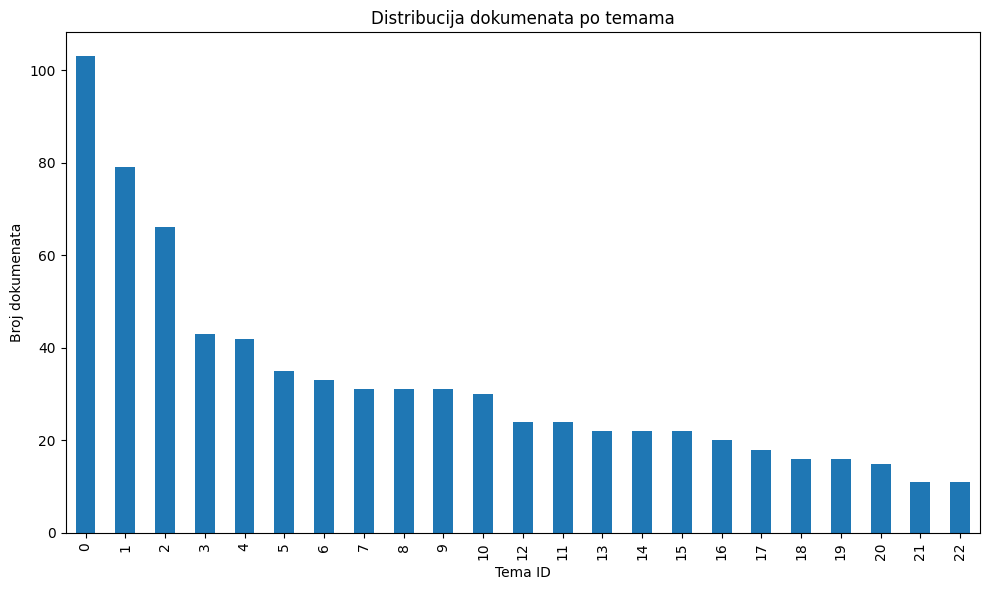

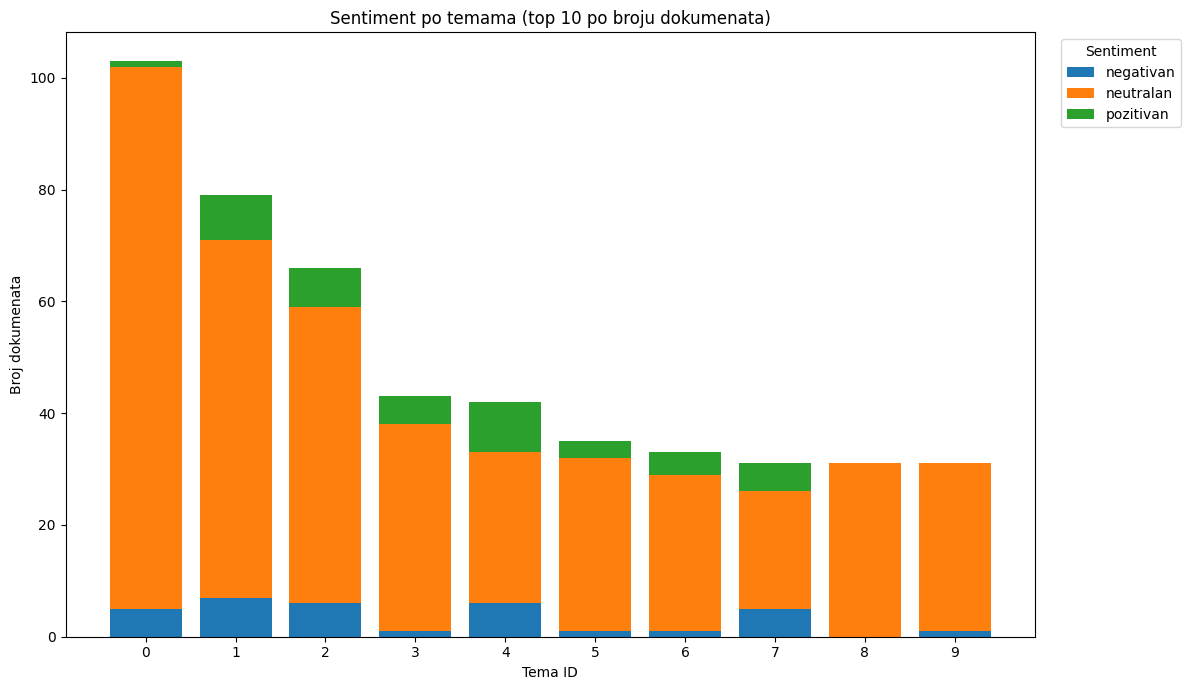

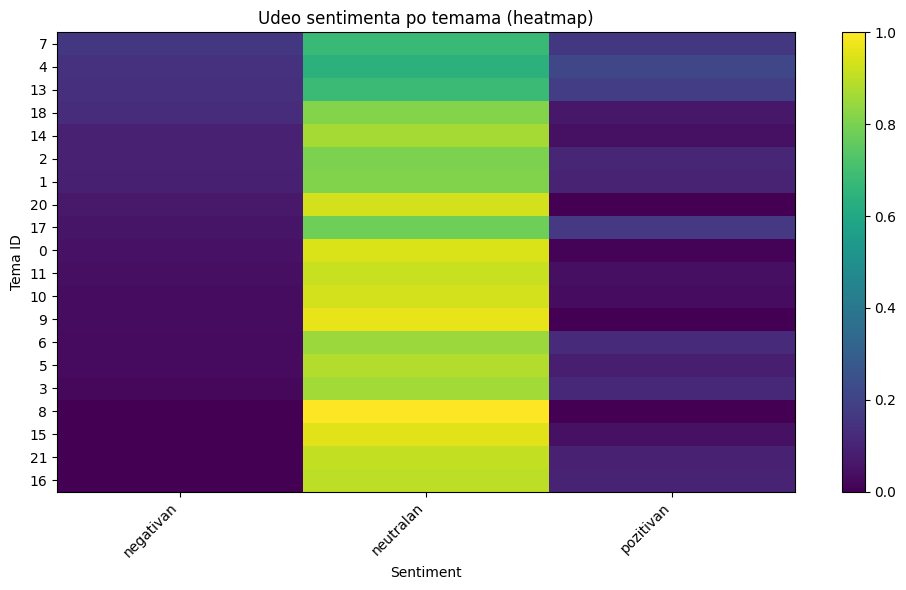

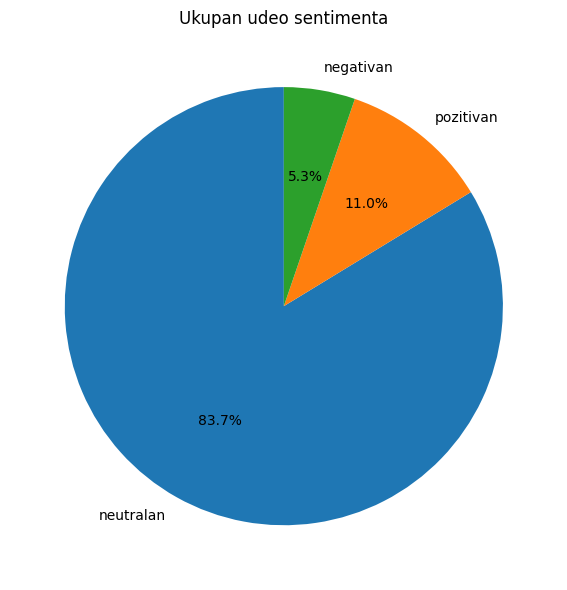

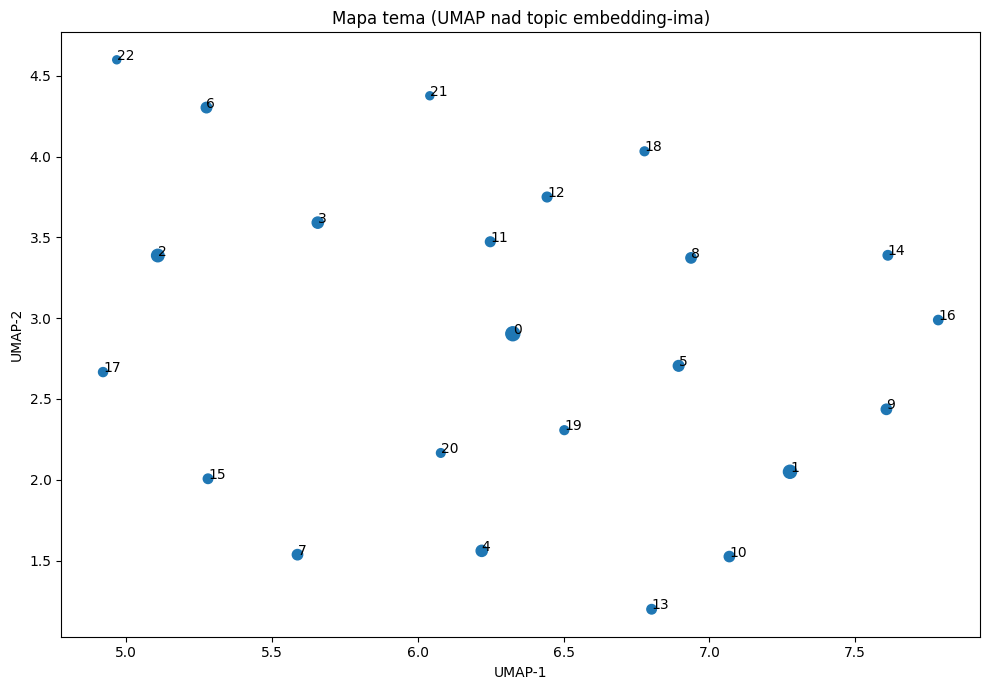


📄 Sačuvan izveštaj: bertopic_outputs/topic_report.txt

✅ Gotovo! Fajlovi/figure su u folderu 'bertopic_outputs/'.


In [5]:
# ===========================
# BERT
# ===========================

# ===========================
# 1) Imports
# ===========================
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# ---------------------------
# 2) Ulaz: očekujemo df sa kol. ['text','sentiment','cleaned_text']
#    Ako df ne postoji u memoriji, učitaj iz fajla:
# ---------------------------
if "df" not in globals():
    df = pd.read_csv("srwac_sentiment_utf8.txt", sep="\t", encoding="utf-8")

assert "cleaned_text" in df.columns, "Nedostaje kolona 'cleaned_text' — prvo pokreni pipeline za čišćenje."
assert "sentiment" in df.columns, "Nedostaje kolona 'sentiment'."

# Filtriraj prazne
df = df[~df["cleaned_text"].isna() & (df["cleaned_text"].str.strip() != "")]
df = df.reset_index(drop=True)

texts = df["cleaned_text"].tolist()
sentiments = df["sentiment"].tolist()

# ===========================
# 3) Modeli za embeddinge i BERTopic konfiguracija
# ===========================
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Rečnik (vectorizer) koji čuva i bigrame/trigrame i srpska slova
vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),
    min_df=2,
    stop_words=None,     # već si čistila tekst; može ostati None
)

# UMAP za smanjenje dimenzionalnosti (za klasterisanje i vizuelizaciju)
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,      # više komponenti često pomaže HDBSCAN-u
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

# Kreiraj BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True,
    low_memory=False
)

# ===========================
# 4) Fit
# ===========================
topics, probs = topic_model.fit_transform(texts)
df["topic"] = topics
df["topic_probability"] = [float(p.max()) if p is not None and hasattr(p, "max") else np.nan for p in probs]

topic_info = topic_model.get_topic_info()
print("📊 Sažetak tema:\n", topic_info.head(10))

# ===========================
# 5) Agregacije sentimenta × tema
# ===========================
# Mapiranje -1 tema je outlier kod BERTopic-a
valid_mask = df["topic"] != -1
df_valid = df[valid_mask].copy()

sentiment_by_topic = (
    df_valid.groupby(["topic", "sentiment"]).size().unstack(fill_value=0).sort_index()
)
sentiment_by_topic["total"] = sentiment_by_topic.sum(axis=1)
sentiment_share = sentiment_by_topic.div(sentiment_by_topic["total"], axis=0)

print("\n📈 Distribucija sentimenta po temama (count):\n", sentiment_by_topic.head())
print("\n📈 Udeo sentimenta po temama (share):\n", sentiment_share.head())

# ===========================
# 6) Folder za rezultate
# ===========================
os.makedirs("bertopic_outputs", exist_ok=True)

# ===========================
# 7) Grafici (Matplotlib, jedan graf po figure)
# ===========================

# 7.1 Broj dokumenata po temi (bar)
def plot_topic_counts():
    counts = sentiment_by_topic["total"].sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    counts.plot(kind="bar")
    plt.title("Distribucija dokumenata po temama")
    plt.xlabel("Tema ID")
    plt.ylabel("Broj dokumenata")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/topic_counts.png", dpi=160)
    plt.show()

# 7.2 Stacked bar sentimenta po top-N temama
def plot_stacked_sentiment(top_n=10):
    top_topics = sentiment_by_topic.sort_values("total", ascending=False).head(top_n).drop(columns=["total"])
    plt.figure(figsize=(12, 7))
    bottom = np.zeros(len(top_topics))
    for col in top_topics.columns:
        plt.bar(top_topics.index.astype(str), top_topics[col].values, bottom=bottom, label=col)
        bottom += top_topics[col].values
    plt.title(f"Sentiment po temama (top {top_n} po broju dokumenata)")
    plt.xlabel("Tema ID")
    plt.ylabel("Broj dokumenata")
    plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/stacked_sentiment_topN.png", dpi=160)
    plt.show()

# 7.3 Heatmap sentiment × tema
def plot_heatmap(max_topics=20):
    matr = sentiment_share.drop(columns=["total"]) if "total" in sentiment_share.columns else sentiment_share.copy()
    matr = matr.sort_values(by=list(matr.columns), ascending=False)
    matr = matr.head(max_topics)
    plt.figure(figsize=(10, 6))
    plt.imshow(matr.values, aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.title("Udeo sentimenta po temama (heatmap)")
    plt.xlabel("Sentiment")
    plt.ylabel("Tema ID")
    plt.xticks(ticks=range(matr.shape[1]), labels=list(matr.columns), rotation=45, ha="right")
    plt.yticks(ticks=range(matr.shape[0]), labels=matr.index.astype(str))
    plt.tight_layout()
    plt.savefig("bertopic_outputs/heatmap_sentiment_topic.png", dpi=160)
    plt.show()

# 7.4 Pie chart ukupne raspodele sentimenta
def plot_sentiment_pie():
    overall = df["sentiment"].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(overall.values, labels=overall.index, autopct="%1.1f%%", startangle=90)
    plt.title("Ukupan udeo sentimenta")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/pie_sentiment.png", dpi=160)
    plt.show()

# 7.5 2D scatter mapa tema (UMAP nad topic embedding-ima)
def plot_topic_scatter():
    emb = topic_model.get_topics()
    # Uzmemo representations (topic embeddings)
    topic_ids = [tid for tid in set(topics) if tid != -1]
    topic_ids = sorted(topic_ids)
    # BERTopic ima metodu get_topic_freq za inf. o temama
    topic_freq = topic_model.get_topic_info().set_index("Topic")["Count"].to_dict()

    # Ugradi teme u 2D za plot
    # Koristi već trenirani embedding prostori: topic_model.topic_embeddings_ (ako postoji)
    if getattr(topic_model, "topic_embeddings_", None) is not None:
        Te = np.array([topic_model.topic_embeddings_[tid] for tid in topic_ids])
    else:
        # fallback: ucrtaj centar dok. embeddinga po temi
        doc_emb = topic_model._extract_embeddings(texts, method="document")
        centers = []
        for tid in topic_ids:
            idxs = np.where(df["topic"].values == tid)[0]
            centers.append(doc_emb[idxs].mean(axis=0))
        Te = np.vstack(centers)

    reducer = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric="cosine", random_state=42)
    T2 = reducer.fit_transform(Te)

    sizes = [max(20, math.sqrt(topic_freq.get(tid, 1))*10) for tid in topic_ids]

    plt.figure(figsize=(10, 7))
    plt.scatter(T2[:,0], T2[:,1], s=sizes)
    for (x, y, tid) in zip(T2[:,0], T2[:,1], topic_ids):
        plt.text(x, y, str(tid))
    plt.title("Mapa tema (UMAP nad topic embedding-ima)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/topic_scatter_umap.png", dpi=160)
    plt.show()

# Pozovi sve grafike
plot_topic_counts()
plot_stacked_sentiment(top_n=10)
plot_heatmap(max_topics=20)
plot_sentiment_pie()
plot_topic_scatter()

# ===========================
# 8) Tekstualni izveštaj po temama
# ===========================
def topic_report(n_examples=2, min_len=20):
    info = topic_model.get_topic_info()
    lines = []
    for _, row in info.iterrows():
        tid = int(row["Topic"])
        if tid == -1:
            continue
        words = topic_model.get_topic(tid)
        kw = ", ".join([w for (w, _) in words[:10]]) if words else ""
        lines.append(f"=== Tema {tid} | Count={int(row['Count'])} ===")
        lines.append(f"Top reči: {kw}")

        # Primeri tekstova po sentimentima
        for s in df["sentiment"].unique():
            subset = df[(df["topic"] == tid) & (df["sentiment"] == s)]
            subset = subset[subset["cleaned_text"].str.len() >= min_len]
            examples = subset.sort_values("topic_probability", ascending=False).head(n_examples)
            if len(examples):
                lines.append(f"  • Primeri ({s}):")
                for _, r in examples.iterrows():
                    snippet = r["text"]
                    snippet = re.sub(r"\s+", " ", str(snippet)).strip()
                    if len(snippet) > 220:
                        snippet = snippet[:220] + "..."
                    lines.append(f"      - {snippet}")
        lines.append("")
    report = "\n".join(lines)
    with open("bertopic_outputs/topic_report.txt", "w", encoding="utf-8") as f:
        f.write(report)
    print("\n📄 Sačuvan izveštaj: bertopic_outputs/topic_report.txt")

topic_report(n_examples=3, min_len=15)

# ===========================
# 9) Snimi rezultate
# ===========================
topic_info.to_csv("bertopic_outputs/topic_info.csv", index=False, encoding="utf-8")
df.to_csv("bertopic_outputs/bertopic_docs_with_topics.csv", index=False, encoding="utf-8")

print("\n✅ Gotovo! Fajlovi/figure su u folderu 'bertopic_outputs/'.")